In [1]:
!pip install sqlalchemy
!pip install pyod
!pip install seaborn

In [2]:
from sqlalchemy import create_engine, Table, inspect
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

In [3]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [4]:
# Create and declare engine
engine = new_engine('mssql', 'KEIKIETS-THINKP', 'AdventureWorks2022', integrated_security=True)

mssql://KEIKIETS-THINKP/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [5]:
print(type(engine))
connection = engine.connect()
print(type(connection))

<class 'sqlalchemy.engine.base.Engine'>
<class 'sqlalchemy.engine.base.Connection'>


In [6]:
inspector = inspect(engine)
schemas = inspector.get_schema_names()
print(schemas)

['db_accessadmin', 'db_backupoperator', 'db_datareader', 'db_datawriter', 'db_ddladmin', 'db_denydatareader', 'db_denydatawriter', 'db_owner', 'db_securityadmin', 'dbo', 'guest', 'HumanResources', 'INFORMATION_SCHEMA', 'Person', 'Production', 'Purchasing', 'Sales', 'sys']


In [7]:
for col in inspector.get_columns(table_name='Customer', schema='Sales'):
#     print(col)
    print(col['name'])

CustomerID
PersonID
StoreID
TerritoryID
AccountNumber
rowguid
ModifiedDate


In [8]:
#Create Query of Number of Employee, Female, Male and % Respectively
sql_cte_employee1 = """
WITH GenderShare_CTE 
AS
(
SELECT SUM(CASE WHEN Gender = 'F' THEN 1 ELSE 0 END) OVER () + SUM(CASE WHEN Gender = 'M' THEN 1 ELSE 0 END) OVER () AS NoE
	, SUM(CASE WHEN Gender = 'F' THEN 1 ELSE 0 END) OVER () AS [NoF]
	, SUM(CASE WHEN Gender = 'M' THEN 1 ELSE 0 END) OVER () AS [NoM]
FROM [HumanResources].[Employee]
)

SELECT TOP 1 *
	, CAST(NoF * 1.0 / NoE * 100 AS DECIMAL (4, 2)) AS [% Female]
	, CAST(NoM * 1.0 / NoE * 100 AS DECIMAL (4, 2)) AS [% Male]
FROM GenderShare_CTE;
"""
result = pd.read_sql(sql_cte_employee1, engine)
result

,NoE,NoF,NoM,% Female,% Male
0,290,84,206,28.97,71.03


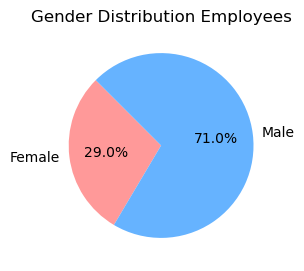

In [9]:
#Create a pie chart displaying % Female and % Male
labels = ['Female', 'Male']
sizes = [result.iloc[0]['% Female'], result.iloc[0]['% Male']]
colors = ["#ff9999", "#66b3ff"]

plt.figure(figsize=(4, 3))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=135)
plt.title('Gender Distribution Employees')

plt.show()


In [10]:
#Create Query of Employee counts per department
sql_employee2 ="""
SELECT 	B.GroupName
	, COUNT(B.GroupName) AS [Counts]
FROM [HumanResources].[EmployeeDepartmentHistory] AS A
INNER JOIN [HumanResources].[Department] AS B
	ON A.DepartmentID = B.DepartmentID
GROUP BY B.GroupName
ORDER BY COUNT(B.GroupName) DESC;
"""
df1 = pd.read_sql(sql=sql_employee2, con=connection)
df1


,GroupName,Counts
0,Manufacturing,186
1,Executive General and Administration,36
2,Sales and Marketing,28
3,Inventory Management,19
4,Research and Development,15
5,Quality Assurance,12


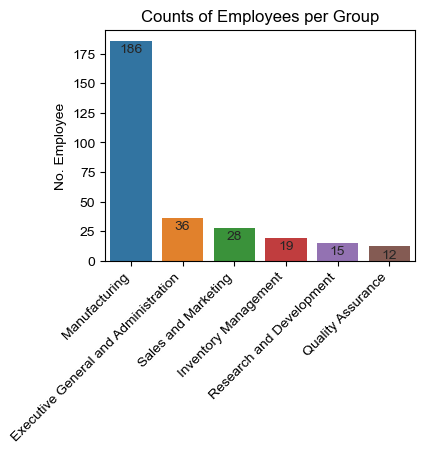

In [11]:
#Create Bar chart displaying No. Employees by GroupCategory
plt.figure(figsize=(4, 3))
g = sns.barplot(x='GroupName', y='Counts', data=df1)
sns.set_style("darkgrid")
plt.xticks(rotation=45, ha='right') # Rotate x-label
plt.title('Counts of Employees per Group')
g.set(xlabel="", ylabel="No. Employee")  # Set custom x- and y-label

# Add text annotation to bars
for p in g.patches:
    g.annotate(f'{int(p.get_height())}',
    (p.get_x() + p.get_width() / 2., p.get_height()), # set annotation x-position to centre of bar
    ha='center', va='center', # set annotation to h- & v- position to centered
    xytext=(0, -6), textcoords='offset points') # offset y-position

plt.show()



In [12]:
# Create Query of Online and Offline Order sales per year.

sql_fig3_ysales = """

   SELECT YEAR(DueDate) AS [Sales Year]
	, OnlineOrderFlag
	, SUM(SubTotal) AS SubTotal
  FROM [AdventureWorks2022].[Sales].[SalesOrderHeader]
  WHERE YEAR(DueDate) <> 2014
  GROUP BY YEAR(DueDate), OnlineOrderFlag
  ORDER BY YEAR(DueDate), SUM(SubTotal)
  
"""

# Declare and convert query data to dataframe 
df2 =  pd.read_sql(sql=sql_fig3_ysales, con = connection)

# Replace True and False with more descriptive labels
df2['OnlineOrderFlag'] = df2['OnlineOrderFlag'].replace({True: 'OnlineOrder', False: 'NormalOrder'})

# Convert SubTotal into Millions
df2['SubTotal']=df2['SubTotal'].astype('float64')/1000000


In [13]:
df2

,Sales Year,OnlineOrderFlag,SubTotal
0,2011,OnlineOrder,3.635321
1,2011,NormalOrder,8.778552
2,2012,OnlineOrder,6.452712
3,2012,NormalOrder,24.748855
4,2013,OnlineOrder,10.347060
5,2013,NormalOrder,32.571387


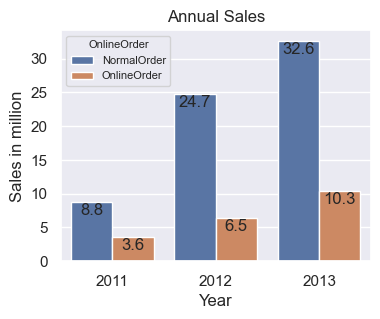

In [14]:
# Create bar plot
plt.figure(figsize=(4, 3))
sns.set(style="darkgrid")

g = sns.barplot(x='Sales Year', y='SubTotal', hue='OnlineOrderFlag', data=df2, hue_order=['NormalOrder', 'OnlineOrder'])

# Set labels, title and legend
plt.title('Annual Sales')
plt.xlabel('Year')
plt.ylabel('Sales in million')
plt.legend(title='OnlineOrder', loc='upper left', prop={'size': 8}, title_fontsize='8')

# Add text annotation to bars
for p in g.patches:
    height = p.get_height()
    g.annotate(f'{height:.1f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, -6), textcoords='offset points')

plt.show()


In [15]:
#Create Query of individual max salary per department

sql_salary = """

WITH CTE_Salary
AS
(
	SELECT A.BusinessEntityID
		, A.Rate
		, MAX(A.Rate) OVER (PARTITION BY A.BusinessEntityID) AS MaxRate
	FROM [AdventureWorks2022].[HumanResources].[EmployeePayHistory] AS A
),

CTE_Max_Salary
	AS
(
SELECT BusinessEntityID
	, Max(MaxRate) AS MaxRate
FROM CTE_Salary
GROUP BY BusinessEntityID
)

SELECT A.BusinessEntityID
	, A.MaxRate
	, C.[GroupName] AS DepartmentName
FROM CTE_Max_Salary AS A
INNER JOIN HumanResources.EmployeeDepartmentHistory AS B
		ON A.BusinessEntityID = B.BusinessEntityID
INNER JOIN [HumanResources].[Department] AS C
		ON B.DepartmentID = C.DepartmentID
ORDER BY BusinessEntityID
"""

In [16]:
# Read SQL Query and convert Query to DataFrame
df3 = pd.read_sql(sql_salary, engine)

#Calculate Mean of Max Salary per departmentname
avg_max_rate_per_department = df3.groupby('DepartmentName')['MaxRate'].mean()
avg_max_rate_per_department.columns = ['DepartmentName', 'AverageMaxRate']

# Merge the original DataFrame with the average MaxRate per department
result_df3 = pd.merge(df3, avg_max_rate_per_department, on='DepartmentName', how='left')

#Rename Columns, in order to name column4 
result_df3.columns = ['BusinessEntityID', 'Salary', 'DepartmentName', 'Avg_Salary_Depart']


In [17]:
result_df3

,BusinessEntityID,Salary,DepartmentName,Avg_Salary_Depart
0,1,125.5000,Executive General and Administration,28.499992
1,2,63.4615,Research and Development,36.939753
2,3,43.2692,Research and Development,36.939753
3,4,29.8462,Research and Development,36.939753
4,4,29.8462,Research and Development,36.939753
...,...,...,...,...
291,286,23.0769,Sales and Marketing,25.696250
292,287,48.1010,Sales and Marketing,25.696250
293,288,23.0769,Sales and Marketing,25.696250
294,289,23.0769,Sales and Marketing,25.696250


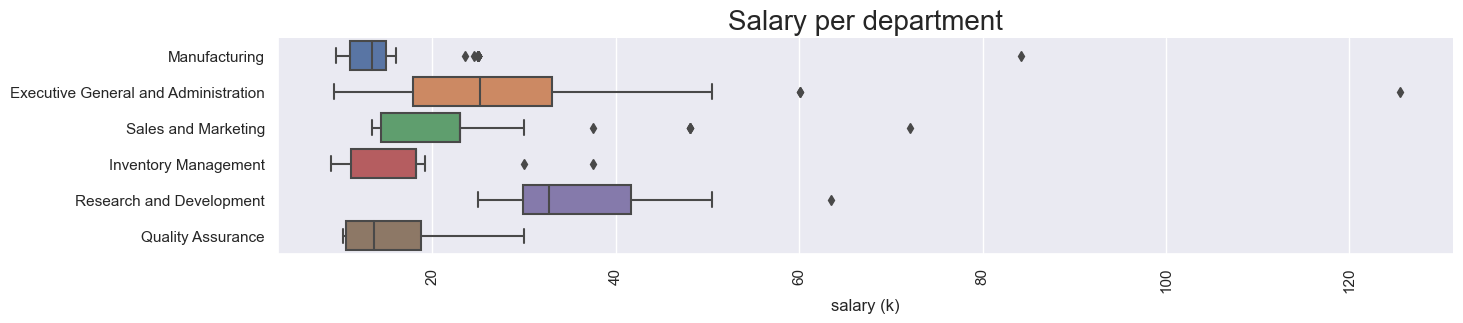

In [18]:
# Set the style of the seaborn plot to darkgrid
sns.set(style="darkgrid")

# Define the order of the departments for better visualization
order = ['Manufacturing', 'Executive General and Administration', 'Sales and Marketing', 'Inventory Management', 'Research and Development', 'Quality Assurance']

# Create a boxplot using seaborn's catplot
g = sns.catplot(x = 'Salary', y = 'DepartmentName', data = result_df3, kind = "box", height = 3, aspect = 5, order = order )

# Set the title and labels of the plot
plt.title('Salary per department', size = 20)
plt.xlabel("salary (k)")
plt.ylabel("")

# Rotate the x-axis labels for better readability
plt.xticks(rotation = 90)

# Display the Plot
plt.show()

In [19]:
#Create Query of sales history 

sql_monthlySales = """

WITH MonthlySales
AS
(
SELECT SalesOrderID
	,FORMAT(OrderDate, 'yy-MM') AS FormattedDate
	,SUM(SubTotal) OVER (PARTITION BY FORMAT(OrderDate, 'yyyy-MM')) AS [Sum]
	,SubTotal
FROM Sales.SalesOrderHeader
)

SELECT FormattedDate
	, SUM(SubTotal) / 1000000 AS SubTotal
FROM MonthlySales
GROUP BY FormattedDate 
ORDER BY FormattedDate

"""
df4 = pd.read_sql(sql_monthlySales, engine)
df4.head()

,FormattedDate,SubTotal
0,11-05,0.5038
1,11-06,0.4589
2,11-07,2.0446
3,11-08,2.4958
4,11-09,0.5020


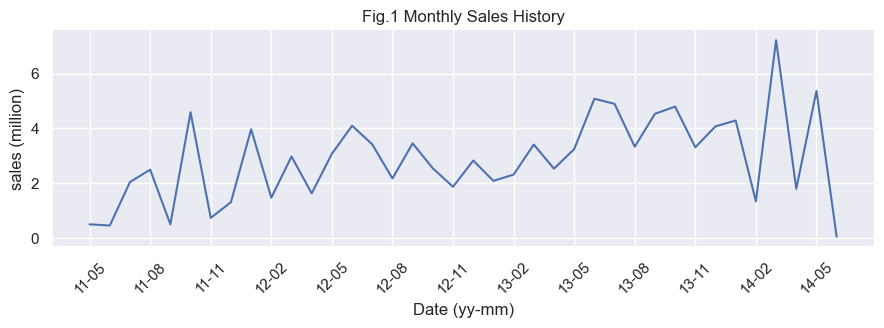

In [20]:
# Create Line plot over sales history
g = sns.relplot(x="FormattedDate", y="SubTotal", data = df4, kind="line", height = 3, aspect = 3)


# Adjust Title, labels and ticks-rotation
plt.title('Fig.1 Monthly Sales History')
plt.xlabel("Date (yy-mm)")
plt.ylabel("sales (million)")
plt.xticks(rotation = 45)

# Show every third x-label tick
tick_positions = np.arange(0, len(df4['FormattedDate']), 3)
plt.xticks(tick_positions, df4['FormattedDate'].iloc[tick_positions])

plt.show()

In [21]:
#Create Query of avg sales per quarter

sql_monthlySales = """

WITH MonthlySales
AS
(
SELECT SalesOrderID
	,CONCAT(DATEPART(year, OrderDate), '-', DATEPART(quarter, OrderDate)) AS YearQuarter
	,SUM(SubTotal) OVER (PARTITION BY FORMAT(OrderDate, 'yyyy-MM')) AS [Sum]
	,SubTotal
FROM Sales.SalesOrderHeader
)

SELECT YearQuarter
	, SUM(SubTotal) / 1000000 / 3 AS SubTotal
FROM MonthlySales
GROUP BY YearQuarter
ORDER BY YearQuarter

"""
df4 = pd.read_sql(sql_monthlySales, engine)
df4 = df4.iloc[1:]
df4.head()


,YearQuarter,SubTotal
1,2011-3,1.6808
2,2011-4,2.2121
3,2012-1,2.8072
4,2012-2,2.9361
5,2012-3,3.0159


In [22]:
df4.describe()

,SubTotal
count,12.000000
mean,3.024492
std,0.851397
min,1.680800
25%,2.412525
50%,2.871650
75%,3.729975
max,4.281600


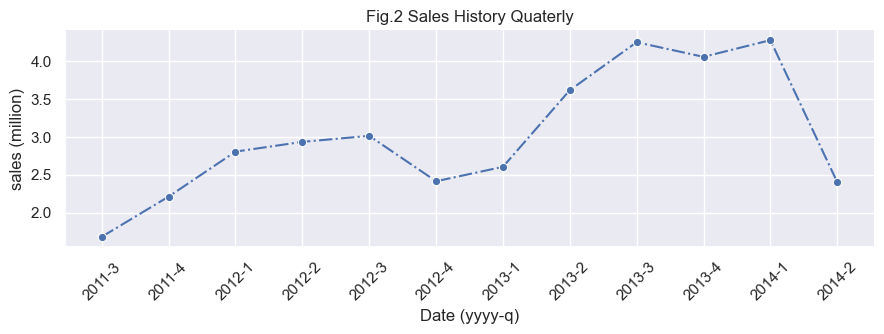

In [23]:
#Create Line plot over sales history Quarterly
g = sns.relplot(x="YearQuarter", y="SubTotal", data = df4, kind="line", height = 3, aspect = 3, marker='o', linestyle='dashdot')


# Adjust Title, labels and xticks-rotation
plt.title('Fig.2 Sales History Quaterly')
plt.xlabel("Date (yyyy-q)")
plt.ylabel("sales (million)")
plt.xticks(rotation = 45)

plt.show()

In [24]:
sql_SalesDetails = """

SELECT A.SalesOrderID
	, A.OrderQty
	, A.ProductID
	, A.UnitPrice
	, A.LineTotal
	, B.OrderDate
	, B.ShipDate
	, B.OnlineOrderFlag
	, B.CustomerID
	, B.SubTotal
	, C.ProductSubcategoryID
	, D. ProductCategoryID
	, D.[Name]
	, F.[Group]

FROM Sales.SalesOrderDetail AS A
INNER JOIN Sales.SalesOrderHeader AS B
	ON A.SalesOrderID = B.SalesOrderID
INNER JOIN Production.Product AS C
	ON A.ProductID = C.ProductID
INNER JOIN Production.ProductSubcategory AS D
	ON C.ProductSubcategoryID = D.ProductSubcategoryID
INNER JOIN Sales.Customer AS E
	ON B.CustomerID = E.CustomerID
INNER JOIN Sales.SalesTerritory AS F
	ON E.TerritoryID = F.TerritoryID
    
"""

df5 = pd.read_sql(sql=sql_SalesDetails, con= connection)
df5.head(10)


,SalesOrderID,OrderQty,ProductID,UnitPrice,LineTotal,OrderDate,ShipDate,OnlineOrderFlag,CustomerID,SubTotal,ProductSubcategoryID,ProductCategoryID,Name,Group
0,43659,1,776,2024.9940,2024.9940,2011-05-31,2011-06-07,False,29825,20565.6206,1,1,Mountain Bikes,North America
1,43659,3,777,2024.9940,6074.9820,2011-05-31,2011-06-07,False,29825,20565.6206,1,1,Mountain Bikes,North America
2,43659,1,778,2024.9940,2024.9940,2011-05-31,2011-06-07,False,29825,20565.6206,1,1,Mountain Bikes,North America
3,43659,1,771,2039.9940,2039.9940,2011-05-31,2011-06-07,False,29825,20565.6206,1,1,Mountain Bikes,North America
4,43659,1,772,2039.9940,2039.9940,2011-05-31,2011-06-07,False,29825,20565.6206,1,1,Mountain Bikes,North America
5,43659,2,773,2039.9940,4079.9880,2011-05-31,2011-06-07,False,29825,20565.6206,1,1,Mountain Bikes,North America
6,43659,1,774,2039.9940,2039.9940,2011-05-31,2011-06-07,False,29825,20565.6206,1,1,Mountain Bikes,North America
7,43659,3,714,28.8404,86.5212,2011-05-31,2011-06-07,False,29825,20565.6206,21,3,Jerseys,North America
8,43659,1,716,28.8404,28.8404,2011-05-31,2011-06-07,False,29825,20565.6206,21,3,Jerseys,North America
9,43659,6,709,5.7000,34.2000,2011-05-31,2011-06-07,False,29825,20565.6206,23,3,Socks,North America


In [25]:
#--------------------

# Extract month and year
df5['YearMonth'] = df5['OrderDate'].dt.to_period('M')

# Identify the first 12 months
Sales_first12M = df5['YearMonth'].unique()[0:12]

print(Sales_first12M)

# Filter data for the first 12 months
Sales_first12M_data = df5[df5['YearMonth'].isin(Sales_first12M)]

# Calculate total sales for each month
monthly_sales = Sales_first12M_data.groupby('YearMonth')['LineTotal'].sum()

# Calculate the mean of the total sales in million
mean_sales = monthly_sales.mean() / 1000000

print(f"The mean sales per month of first 12M is: {mean_sales}")

<PeriodArray>
['2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
 '2011-12', '2012-01', '2012-02', '2012-03', '2012-04']
Length: 12, dtype: period[M]
The mean sales per month of first 12M is: 1.891506286554333


In [26]:
#----------------------
# Extract month and year
df5['YearMonth'] = df5['OrderDate'].dt.to_period('M')

# Identify the 2nd 12 months
Sales_second12M = df5['YearMonth'].unique()[12:24]

print(Sales_second12M)

# Filter data for the 2nd 12 months
Sales_second12M_data = df5[df5['YearMonth'].isin(Sales_second12M)]

# Calculate total sales for each month
monthly_sales_second12M = Sales_second12M_data.groupby('YearMonth')['LineTotal'].sum()

# Calculate the mean of the total sales in million
mean_sales2 = monthly_sales_second12M.mean() / 1000000

print(f"The mean sales per month of second 12M is: {mean_sales2}")

<PeriodArray>
['2012-05', '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11',
 '2012-12', '2013-01', '2013-02', '2013-03', '2013-04']
Length: 12, dtype: period[M]
The mean sales per month of second 12M is: 2.818085632721167


In [27]:
#------------------------------------------------
# Extract month and year
df5['YearMonth'] = df5['OrderDate'].dt.to_period('M')

# Identify the 3rd 12 months
Sales_third12M = df5['YearMonth'].unique()[24:35]

print(Sales_third12M)

# Filter data for the 3rd 12 months
Sales_third12M_data = df5[df5['YearMonth'].isin(Sales_third12M)]

# Calculate total sales for each month
monthly_Sales_third12M = Sales_third12M_data.groupby('YearMonth')['LineTotal'].sum()

# Calculate the mean of the total sales in million
mean_sales3 = monthly_Sales_third12M.mean() / 1000000

print(f"The mean sales per month of second 12M is: {mean_sales3}")

<PeriodArray>
['2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11',
 '2013-12', '2014-01', '2014-02', '2014-03']
Length: 11, dtype: period[M]
The mean sales per month of second 12M is: 4.192583966931273


In [28]:
print('1st 12M: ' + str(round(mean_sales, 2)))
print('2nd 12M: ' + str(round(mean_sales2, 2)))
print('3rd 12M: ' + str(round(mean_sales3, 2)))


1st 12M: 1.89
2nd 12M: 2.82
3rd 12M: 4.19


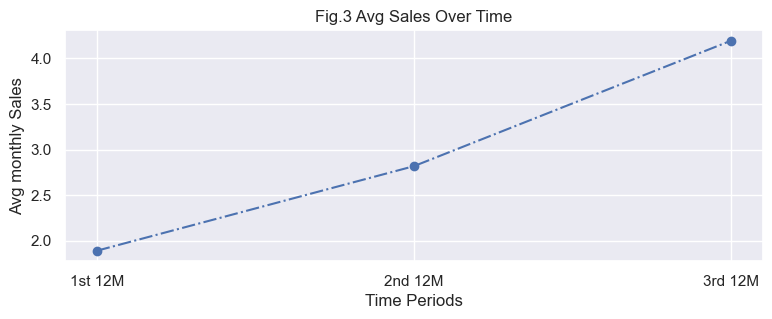

In [29]:
# Labels for the x-axis (assuming three different time periods)
time_periods = ['1st 12M', '2nd 12M', '3rd 12M']

# Means to be plotted
means = [mean_sales, mean_sales2, mean_sales3]

# Create a line plot
plt.figure(figsize=(9, 3))
plt.plot(time_periods, means, marker='o', linestyle='dashdot')


# Add labels and title
plt.xlabel('Time Periods')
plt.ylabel('Avg monthly Sales')
plt.title('Fig.3 Avg Sales Over Time')

# Show the plot
plt.show()


In [30]:
sql_BigSalesData = """

SELECT A.SalesOrderID
	, A.OrderQty
	, A.ProductID
	, A.UnitPrice
	, A.LineTotal
	, B.OrderDate
	, B.ShipDate
	, B.OnlineOrderFlag
	, B.SubTotal
	, C.ProductSubcategoryID
	, D. ProductCategoryID
	, D.[Name]
	, F.[Group]
	, G.CustomerID
	, G.PersonID
	, G.StoreID

FROM Sales.SalesOrderDetail AS A
INNER JOIN Sales.SalesOrderHeader AS B
	ON A.SalesOrderID = B.SalesOrderID
INNER JOIN Production.Product AS C
	ON A.ProductID = C.ProductID
INNER JOIN Production.ProductSubcategory AS D
	ON C.ProductSubcategoryID = D.ProductSubcategoryID
INNER JOIN Sales.Customer AS E
	ON B.CustomerID = E.CustomerID
INNER JOIN Sales.SalesTerritory AS F
	ON E.TerritoryID = F.TerritoryID
INNER JOIN Sales.Customer AS G
	ON B.CustomerID = G.CustomerID
    
"""

df6 = pd.read_sql(sql = sql_BigSalesData, con=connection)
df6.head(10)


,SalesOrderID,OrderQty,ProductID,UnitPrice,LineTotal,OrderDate,ShipDate,OnlineOrderFlag,SubTotal,ProductSubcategoryID,ProductCategoryID,Name,Group,CustomerID,PersonID,StoreID
0,43659,1,776,2024.9940,2024.9940,2011-05-31,2011-06-07,False,20565.6206,1,1,Mountain Bikes,North America,29825,1045,1046.0
1,43659,3,777,2024.9940,6074.9820,2011-05-31,2011-06-07,False,20565.6206,1,1,Mountain Bikes,North America,29825,1045,1046.0
2,43659,1,778,2024.9940,2024.9940,2011-05-31,2011-06-07,False,20565.6206,1,1,Mountain Bikes,North America,29825,1045,1046.0
3,43659,1,771,2039.9940,2039.9940,2011-05-31,2011-06-07,False,20565.6206,1,1,Mountain Bikes,North America,29825,1045,1046.0
4,43659,1,772,2039.9940,2039.9940,2011-05-31,2011-06-07,False,20565.6206,1,1,Mountain Bikes,North America,29825,1045,1046.0
5,43659,2,773,2039.9940,4079.9880,2011-05-31,2011-06-07,False,20565.6206,1,1,Mountain Bikes,North America,29825,1045,1046.0
6,43659,1,774,2039.9940,2039.9940,2011-05-31,2011-06-07,False,20565.6206,1,1,Mountain Bikes,North America,29825,1045,1046.0
7,43659,3,714,28.8404,86.5212,2011-05-31,2011-06-07,False,20565.6206,21,3,Jerseys,North America,29825,1045,1046.0
8,43659,1,716,28.8404,28.8404,2011-05-31,2011-06-07,False,20565.6206,21,3,Jerseys,North America,29825,1045,1046.0
9,43659,6,709,5.7000,34.2000,2011-05-31,2011-06-07,False,20565.6206,23,3,Socks,North America,29825,1045,1046.0


In [31]:
df6.describe()

,SalesOrderID,OrderQty,ProductID,UnitPrice,LineTotal,SubTotal,ProductSubcategoryID,ProductCategoryID,CustomerID,PersonID,StoreID
count,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000,60919.000000
mean,57827.363782,2.266080,841.680836,465.093496,905.449207,21402.362873,17.362043,2.525491,24345.630505,6277.684422,1047.565029
std,9009.147902,2.491323,86.452124,751.885081,1693.417389,28509.182428,13.193571,1.260324,6689.110387,6485.217148,486.727460
min,43659.000000,1.000000,707.000000,1.328200,1.374000,1.374000,1.000000,1.000000,11000.000000,291.000000,292.000000
25%,49884.000000,1.000000,768.000000,21.490000,24.990000,564.480000,2.000000,1.000000,18177.000000,979.000000,652.000000
50%,57029.000000,1.000000,863.000000,49.990000,134.982000,2518.980000,19.000000,3.000000,29485.000000,1991.000000,982.000000
75%,65490.000000,3.000000,921.000000,602.346000,1120.490000,37202.781200,30.000000,4.000000,29795.000000,11604.000000,1334.000000
max,75123.000000,44.000000,999.000000,3578.270000,27893.619000,163930.394300,37.000000,4.000000,30118.000000,20777.000000,1994.000000


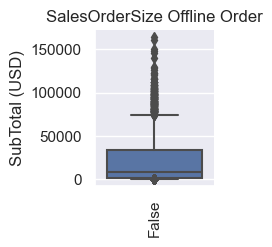

In [53]:
sql_SalesOrderHeader = """
SELECT OnlineOrderFlag
    , SubTotal
  FROM [AdventureWorks2022].[Sales].[SalesOrderHeader]
  WHERE OnlineOrderFlag = 0
"""

df10 = pd.read_sql(sql = sql_SalesOrderHeader, con = connection)

# Create Box Plot displaying SalesOrderSize OfflineOrder
sns.set_style = "darkgrid"

g = sns.catplot(x = 'OnlineOrderFlag', y = 'SubTotal', data = df10, kind = 'box', whis=[5,95], height = 2.4, aspect = 1)

plt.title('SalesOrderSize Offline Order')
plt.xlabel("")
plt.ylabel("SubTotal (USD)")
plt.xticks(rotation = 90)
plt.show()

In [54]:
df10.describe()

,SubTotal
count,3806.000000
mean,21147.583863
std,25559.645345
min,1.374000
25%,1544.970000
50%,8257.084900
75%,34122.384675
max,163930.394300


In [34]:
Offline_order_amounts = df10.SubTotal

In [35]:
# Calculate confidence interval for the average Offline order amount
ci = stats.norm.interval(0.95, loc=np.mean(Offline_order_amounts), scale=stats.sem(Offline_order_amounts))

print(f"Confidence Interval for Average Order Amount: {ci}")

Confidence Interval for Average Order Amount: (20335.560504223435, 21959.607222103416)


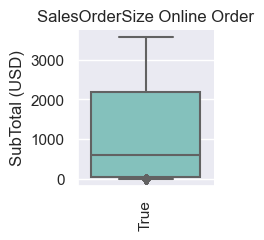

In [55]:
sql_SalesOrderHeader2 = """
SELECT OnlineOrderFlag
    , SubTotal
  FROM [AdventureWorks2022].[Sales].[SalesOrderHeader]
  WHERE OnlineOrderFlag = 1
"""

df11 = pd.read_sql(sql = sql_SalesOrderHeader2, con = connection)

# Create Box Plot displaying SalesOrderSize OnlineOrder
sns.set_style = "darkgrid"

g = sns.catplot(x = 'OnlineOrderFlag', y = 'SubTotal', data = df11, kind = 'box', whis = [5, 95], palette="GnBu", height = 2.4, aspect = 1)

plt.title('SalesOrderSize Online Order')
plt.xlabel("")
plt.ylabel("SubTotal (USD)")
plt.xticks(rotation = 90)
plt.show()

In [56]:
df11.describe()

,SubTotal
count,27659.000000
mean,1061.451145
std,1149.026001
min,2.290000
25%,46.470000
50%,594.970000
75%,2181.562500
max,3578.270000


In [38]:
Online_order_amounts = df11.SubTotal

In [39]:
# Calculate confidence interval for the average Online order amount
ci = stats.norm.interval(0.95, loc=np.mean(Online_order_amounts), scale=stats.sem(Online_order_amounts))

print(f"Confidence Interval for Average Order Amount: {ci}")

Confidence Interval for Average Order Amount: (1047.909865292772, 1074.9924247900215)


In [40]:
sql_avgOnOffOrder = """

--Query that counts number of Online and Offline Order + calculates avg of respective order form.
SELECT SalesOrderID
	, Avg(SubTotal) OVER (PARTITION BY OnlineOrderFlag) AS AvgSubTotalPerOrderCategory
	, SUM(SubTotal) OVER (PARTITION BY OnlineOrderFlag) AS SumSubTotalPerOrderCategory
	, OnlineOrderFlag
	, COUNT(OnlineOrderFlag) OVER (PARTITION BY OnlineOrderFlag) AS CountOfOrderCategory
FROM Sales.SalesOrderHeader
"""

df7 = pd.read_sql(sql=sql_avgOnOffOrder, con = connection)
df7.head(10)

,SalesOrderID,AvgSubTotalPerOrderCategory,SumSubTotalPerOrderCategory,OnlineOrderFlag,CountOfOrderCategory
0,43659,21147.5838,8.048770e+07,False,3806
1,43660,21147.5838,8.048770e+07,False,3806
2,43661,21147.5838,8.048770e+07,False,3806
3,43662,21147.5838,8.048770e+07,False,3806
4,43663,21147.5838,8.048770e+07,False,3806
5,43664,21147.5838,8.048770e+07,False,3806
6,43665,21147.5838,8.048770e+07,False,3806
7,43666,21147.5838,8.048770e+07,False,3806
8,43667,21147.5838,8.048770e+07,False,3806
9,43668,21147.5838,8.048770e+07,False,3806


In [41]:
#Create Query that sums Online TotalLineOrder per ProductCategoryName as SubTotalPerCategory

sql_SalesCategoryOnlineOrders = """

  SELECT OnlineOrderFlag
	, ProductCategoryID
	, COUNT(ProductCategoryID) OVER (PARTITION BY ProductCategoryID) AS CountOProdCategory
	, ProductCategoryName
	, SubTotal AS TotalLineOrder
	, SUM(LineTotal / 1000000) OVER (PARTITION BY ProductCategoryID) AS SubTotalPerCategory
  FROM Sales.vOrderDetailView
  WHERE OnlineOrderFlag = 1
"""

df8 = pd.read_sql(sql = sql_SalesCategoryOnlineOrders, con = connection)
df8.head(10)

,OnlineOrderFlag,ProductCategoryID,CountOProdCategory,ProductCategoryName,TotalLineOrder,SubTotalPerCategory
0,True,1,15205,Bikes,3578.2700,28.308825
1,True,1,15205,Bikes,3399.9900,28.308825
2,True,1,15205,Bikes,3399.9900,28.308825
3,True,1,15205,Bikes,699.0982,28.308825
4,True,1,15205,Bikes,3399.9900,28.308825
5,True,1,15205,Bikes,3578.2700,28.308825
6,True,1,15205,Bikes,3578.2700,28.308825
7,True,1,15205,Bikes,3374.9900,28.308825
8,True,1,15205,Bikes,3399.9900,28.308825
9,True,1,15205,Bikes,3578.2700,28.308825


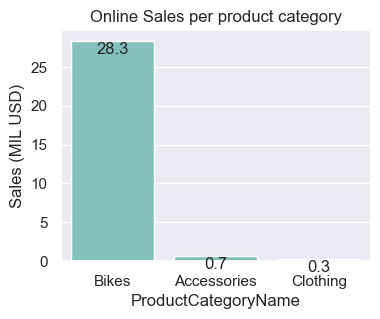

In [42]:
# Create bar plot
plt.figure(figsize=(4, 3))
sns.set(style="darkgrid")
order = ['Bikes', 'Accessories', 'Clothing']

g = sns.barplot(x='ProductCategoryName', y='SubTotalPerCategory', hue='OnlineOrderFlag', data=df8, order = order, palette="GnBu")
g.get_legend().set_visible(False)

# Set labels, title and legend
plt.title('Online Sales per product category')
plt.ylabel('Sales (MIL USD)')

# Add visual values to the bars
for p in g.patches:
    height = p.get_height()
    g.annotate(f'{height:.1f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, -6), textcoords='offset points')

plt.show()


In [43]:
sql_SalesCategoryOfflineOrders = """

  SELECT OnlineOrderFlag
	, ProductCategoryID
	, COUNT(ProductCategoryID) OVER (PARTITION BY ProductCategoryID) AS CountOProdCategory
	, ProductCategoryName
	, SubTotal AS TotalLineOrder
	, SUM(LineTotal / 1000000) OVER (PARTITION BY ProductCategoryID) AS SubTotalPerCategory
  FROM Sales.vOrderDetailView
  WHERE OnlineOrderFlag = 0
"""

df9 = pd.read_sql(sql = sql_SalesCategoryOfflineOrders, con = connection)
df9.describe()

,ProductCategoryID,CountOProdCategory,TotalLineOrder,SubTotalPerCategory
count,60919.000000,60919.000000,60919.000000,60919.000000
mean,1.961769,18764.157865,41649.457078,31.050507
std,0.971017,6249.761930,28178.890185,29.520825
min,1.000000,5102.000000,1.374000,0.568231
25%,1.000000,12293.000000,23686.980000,1.772712
50%,2.000000,18698.000000,37020.040100,11.792522
75%,3.000000,24826.000000,56353.869000,66.316691
max,4.000000,24826.000000,163930.394300,66.316691


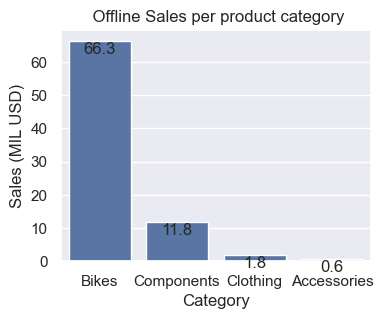

In [44]:
plt.figure(figsize=(4, 3))
sns.set(style="darkgrid")

# Create bar plot
g = sns.barplot(x='ProductCategoryName', y='SubTotalPerCategory', hue='OnlineOrderFlag', data=df9)
g.get_legend().set_visible(False)

# Set labels, title and legend
plt.title(' Offline Sales per product category')
plt.xlabel('Category')
plt.ylabel('Sales (MIL USD)')

# Add visual values to the bars
for p in g.patches:
    height = p.get_height()
    g.annotate(f'{height:.1f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, -6), textcoords='offset points')

plt.show()


In [45]:
#Create Query of avg sales per quarter

sql_monthlySales = """

WITH MonthlySales
AS
(
SELECT SalesOrderID
	,CONCAT(DATEPART(year, OrderDate), '-', DATEPART(quarter, OrderDate)) AS YearQuarter
	,SUM(SubTotal) OVER (PARTITION BY FORMAT(OrderDate, 'yyyy-MM')) AS [Sum]
	,SubTotal
FROM Sales.SalesOrderHeader
)

SELECT YearQuarter
	, SUM(SubTotal) / 1000000 AS SubTotal
FROM MonthlySales
GROUP BY YearQuarter
ORDER BY YearQuarter

"""
df4 = pd.read_sql(sql_monthlySales, engine)
df4 = df4.iloc[1:]


In [46]:
df4.describe()

,SubTotal
count,12.000000
mean,9.073583
std,2.554193
min,5.042400
25%,7.237775
50%,8.615150
75%,11.190025
max,12.845000


In [47]:
df4

,YearQuarter,SubTotal
1,2011-3,5.0424
2,2011-4,6.6364
3,2012-1,8.4218
4,2012-2,8.8085
5,2012-3,9.0477
6,2012-4,7.2461
7,2013-1,7.8168
8,2013-2,10.8589
9,2013-3,12.7632
10,2013-4,12.1834


In [48]:
# Forecast Model 1
# Calculate confidence interval for the average sales per quarter
ci = stats.norm.interval(0.95, loc=np.mean(df4['SubTotal']), scale=stats.sem(df4['SubTotal']))

ci

(7.628438890873065, 10.518727775793602)

In [49]:
# Forecast Model 2
# Calculate confidence interval for the average sales per quarter
ci = stats.norm.interval(0.95, loc=(9.1*1.25), scale=stats.sem(df4['SubTotal']))

ci


(9.929855557539732, 12.820144442460268)

In [50]:
# Forecast Model 3
# Calculate confidence interval for the average sales per quarter
ci = stats.norm.interval(0.95, loc=(9.1*1.25), scale=stats.sem(df4['SubTotal']*1.125))

ci

(9.749212502232197, 13.000787497767803)

In [ ]:
sql_BTB = """

SELECT A.SubTotal
	, A.[Status]
	, A.OnlineOrderFlag
	, B.PersonID
	, B.StoreID
	, COUNT(B.PersonID) OVER (PARTITION BY [Status]) AS [No_UniqueCustOrders]
	, COUNT(B.StoreID) OVER (PARTITION BY [Status]) AS [No_BTB_Orders]
	, (COUNT(B.PersonID) OVER (PARTITION BY [Status]) - COUNT(B.StoreID) OVER (PARTITION BY [Status])) AS [No_BTC_orders]
	, CASE WHEN StoreID IS NULL THEN 1 
	ELSE 0 
	END [BTC/BTB]
FROM Sales.SalesOrderHeader AS A
INNER JOIN Sales.Customer AS B
ON A.CustomerID = B.CustomerID
"""

df10 = pd.read_sql(sql=sql_BTB, con=connection)


In [ ]:
df10